In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import statistics
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, NASNetLarge, DenseNet201, EfficientNetV2S, MobileNet, ResNet152, InceptionV3, Xception
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from keras.models import Model, Sequential
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
plt.style.use('seaborn')
RANDOM_SEED = 123

<ipython-input-2-1400d5d641d9>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
def load_data(dir_path, img_size=(256,256)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/Alzheimer Dataset/Training/'
TEST_DIR = '/content/drive/MyDrive/Alzheimer Dataset/Testing/'
IMG_SIZE = (256,256)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


507 images loaded from /content/drive/MyDrive/Alzheimer Dataset/Training/ directory.


100%|██████████| 2/2 [00:59<00:00, 29.63s/it]

150 images loaded from /content/drive/MyDrive/Alzheimer Dataset/Testing/ directory.


In [ ]:
print(len(os.listdir(TRAIN_DIR + "MCI")))
print(len(os.listdir(TRAIN_DIR + "CN")))
print(len(os.listdir(TEST_DIR + "MCI")))
print(len(os.listdir(TEST_DIR + "CN")))

339
168
71
79


In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 5
        i = int(n/j)

        plt.figure(figsize=(20,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]), fontsize = 10)
        plt.show()

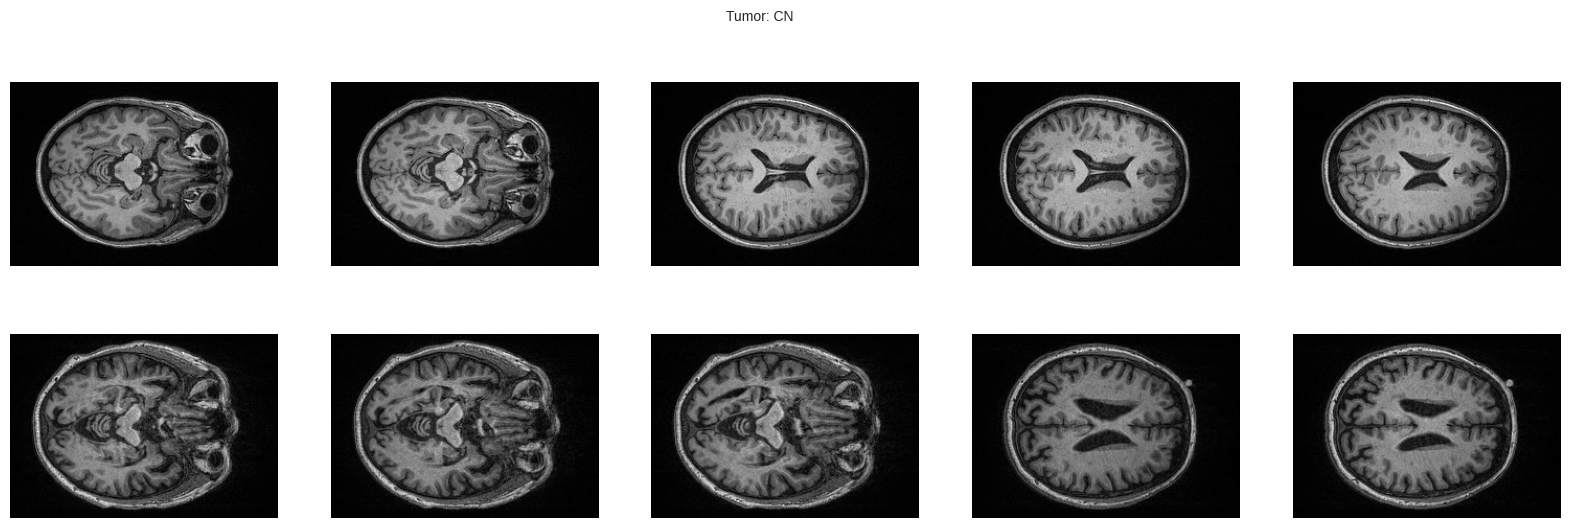

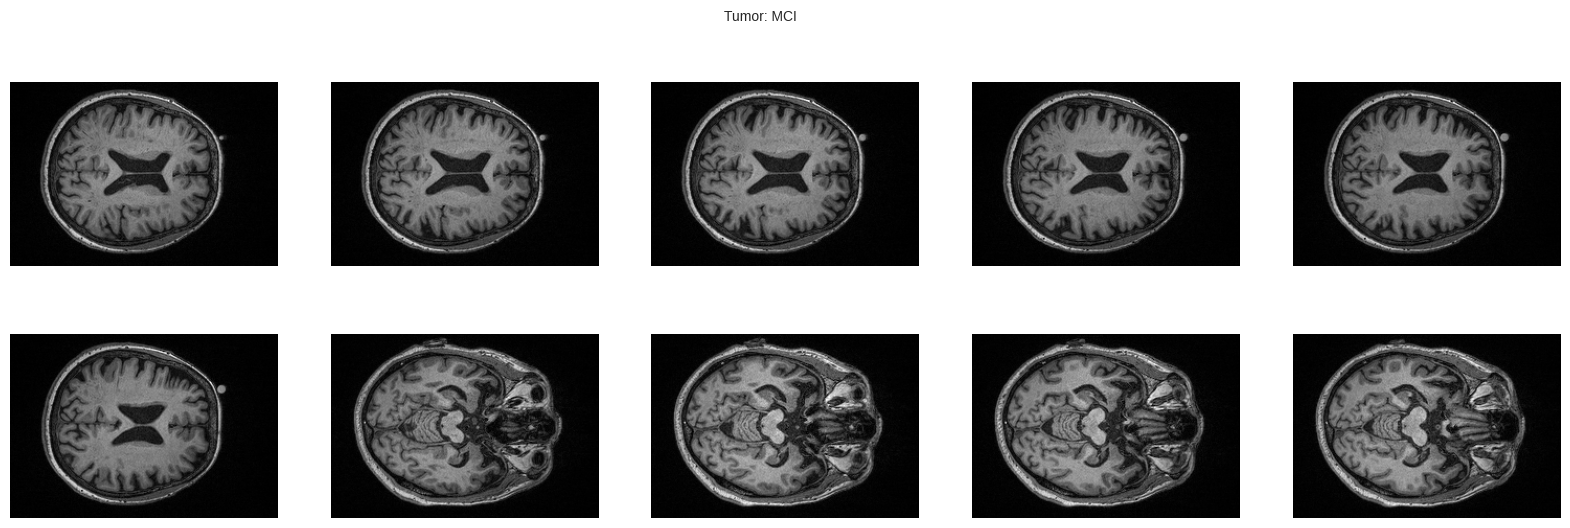

In [ ]:
plot_samples(X_train, y_train, labels, 10)

In [ ]:
classes = os.listdir('/content/drive/MyDrive/Alzheimer Dataset/Training/')
classes

['CN', 'MCI']

In [ ]:
X = []
y = []
image_size = 256
for i in classes:
    folderPath = os.path.join('/content/drive/MyDrive/Alzheimer Dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)
        
for i in classes:
    folderPath = os.path.join('/content/drive/MyDrive/Alzheimer Dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X.append(img)
        y.append(i)
        
X = np.array(X)
y = np.array(y)

100%|██████████| 71/71 [00:00<00:00, 402.45it/s]


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25,random_state=101)
y_train_new = []
for i in y_train:
    y_train_new.append(classes.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(classes.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
img_datagen = ImageDataGenerator(
    rotation_range=25,
    rescale = 1./255,
    horizontal_flip=True)
img_datagen.fit(X_train)
img_datagen.fit(X_test)

In [ ]:
def exponential_decay(lr, s):
    def exponential_decay_fn(epoch):
        return lr * 0.01
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.1, 5) 

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

## VGG19

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

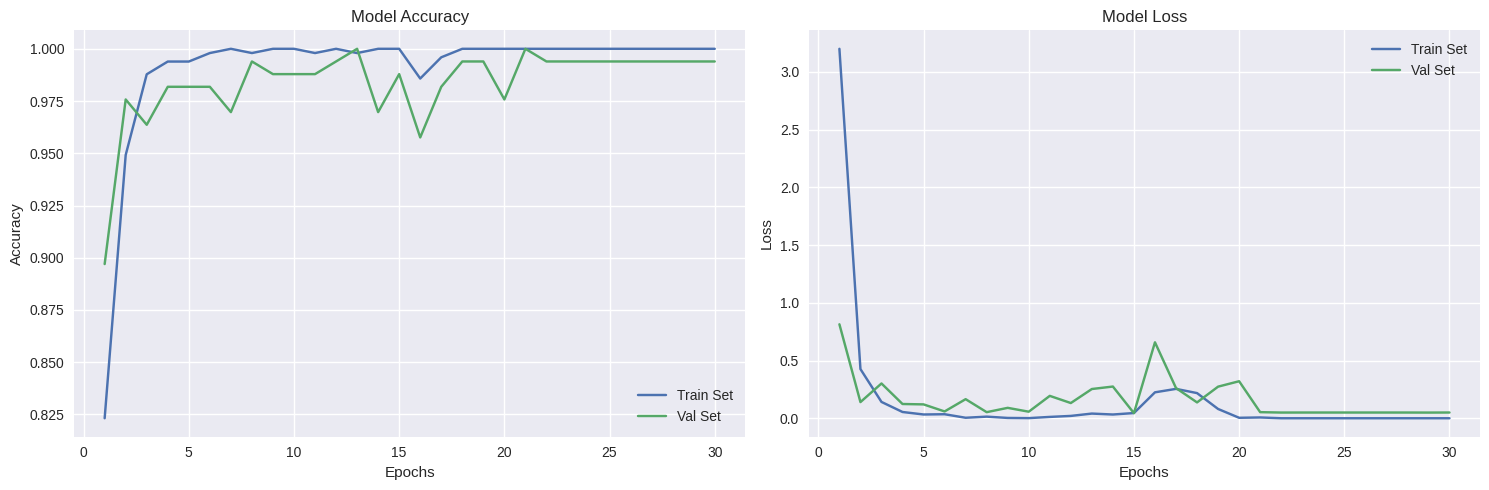

0.9907181580861409
0.16159220058571425
0.9836363712946574
0.16558810745676358
6/6 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        57
           1       1.00      0.99      1.00       108

    accuracy                           0.99       165
   macro avg       0.99      1.00      0.99       165
weighted avg       0.99      0.99      0.99       165

The AUC score for VGG19 model is 0.9990253411306043


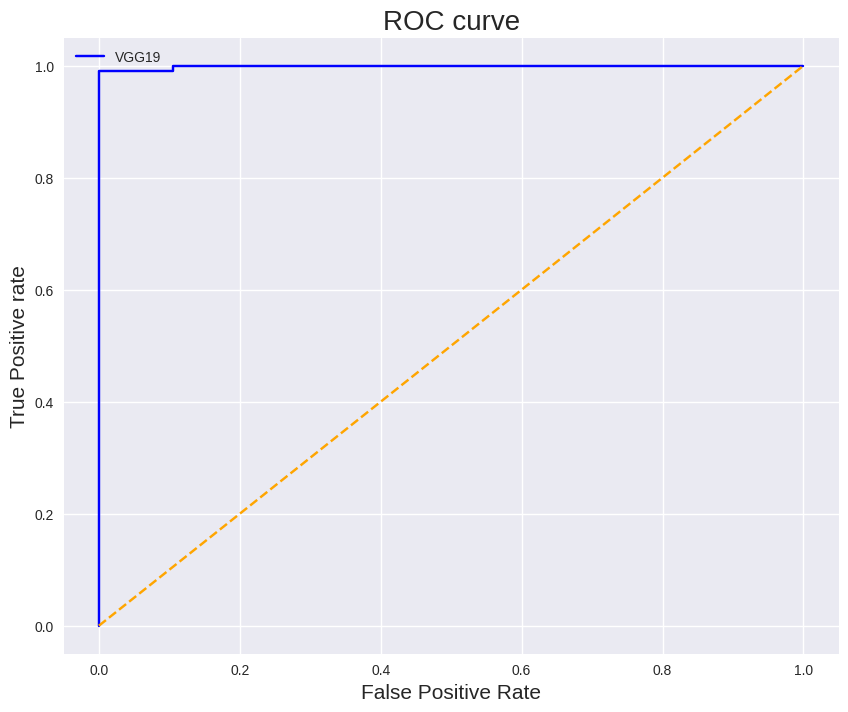

In [ ]:
VGGmodel = VGG19(weights = "imagenet", include_top = False,
                 input_tensor = Input(shape = (256,256,3)))
outputs = VGGmodel.output
outputs = Flatten(name = "flatten")(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation = "sigmoid")(outputs)

model = Model(inputs=VGGmodel.input, outputs=outputs)

for layers in VGGmodel.layers:
  layers.trainable = False

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()

history=model.fit(X_train,y_train,
                  epochs = 30,
                  verbose = 1,
                  validation_data=(X_test,y_test),
                  batch_size = 16,
                  callbacks=lr_scheduler)
model.save('VGG19.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

print(statistics.mean(acc))
print(statistics.mean(loss))
print(statistics.mean(val_acc))
print(statistics.mean(val_loss))

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


pred_prob1 = model.predict_on_batch(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test.argmax(axis=1), pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test.argmax(axis=1), random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test.argmax(axis=1), pred_prob1[:,1])
print("The AUC score for VGG19 model is {}".format(auc_score1))


plt.figure(figsize = (10, 8))
plt.plot(fpr1, tpr1, linestyle= None ,color='blue', label='VGG19')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve',size = 20)
plt.xlabel('False Positive Rate',size = 15)
plt.ylabel('True Positive rate',size = 15)
plt.legend()
plt.savefig('ROC',dpi=700)
plt.show();

# DenseNet201

74836368/74836368 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                           

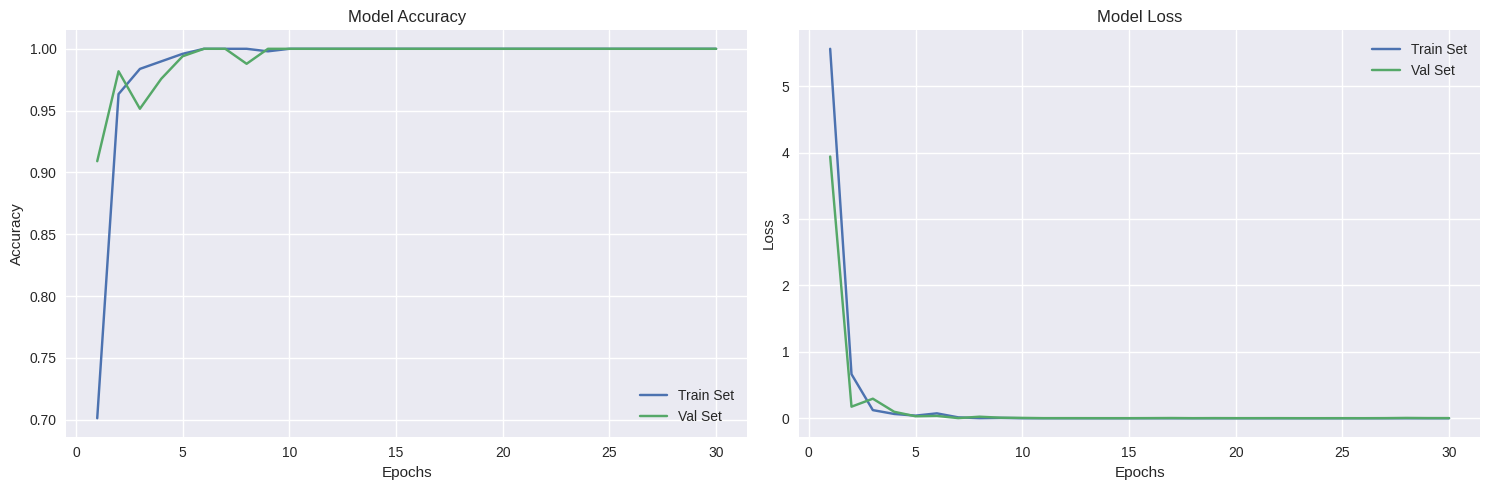

0.9877371271451314
0.21829868681488734
0.9933333357175191
0.15499080621715014
6/6 [==============================] - 3s 28ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00       108

    accuracy                           1.00       165
   macro avg       1.00      1.00      1.00       165
weighted avg       1.00      1.00      1.00       165

The AUC score for DenseNet model is 1.0


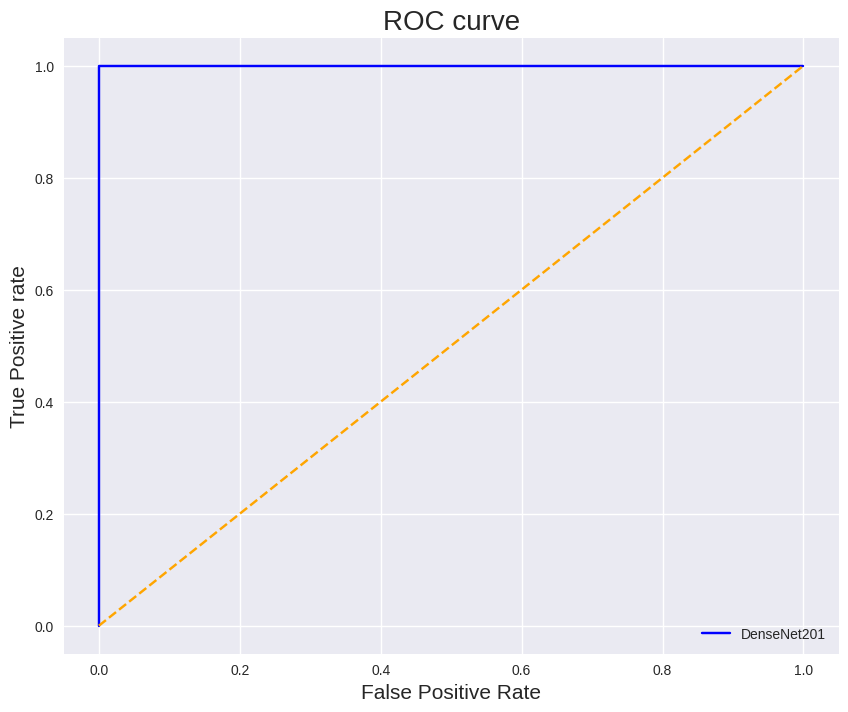

In [ ]:
DenseNetmodel = DenseNet201(weights = "imagenet", include_top = False,
                 input_tensor = Input(shape = (256,256,3)))
outputs = DenseNetmodel.output
outputs = Flatten(name = "flatten")(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation = "sigmoid")(outputs)

model = Model(inputs=DenseNetmodel.input, outputs=outputs)

for layers in DenseNetmodel.layers:
  layers.trainable = False

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()

history=model.fit(X_train,y_train,
                  epochs = 30,
                  verbose = 1,
                  validation_data=(X_test,y_test),
                  batch_size = 16,
                  callbacks=lr_scheduler)
model.save('DenseNet.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

print(statistics.mean(acc))
print(statistics.mean(loss))
print(statistics.mean(val_acc))
print(statistics.mean(val_loss))

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


pred_prob1 = model.predict_on_batch(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test.argmax(axis=1), pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test.argmax(axis=1), random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test.argmax(axis=1), pred_prob1[:,1])
print("The AUC score for DenseNet model is {}".format(auc_score1))


plt.figure(figsize = (10, 8))
plt.plot(fpr1, tpr1, linestyle= None ,color='blue', label='DenseNet201')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve',size = 20)
plt.xlabel('False Positive Rate',size = 15)
plt.ylabel('True Positive rate',size = 15)
plt.legend()
plt.savefig('ROC',dpi=700)
plt.show();

# EfficientNetV2S

82420632/82420632 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                           

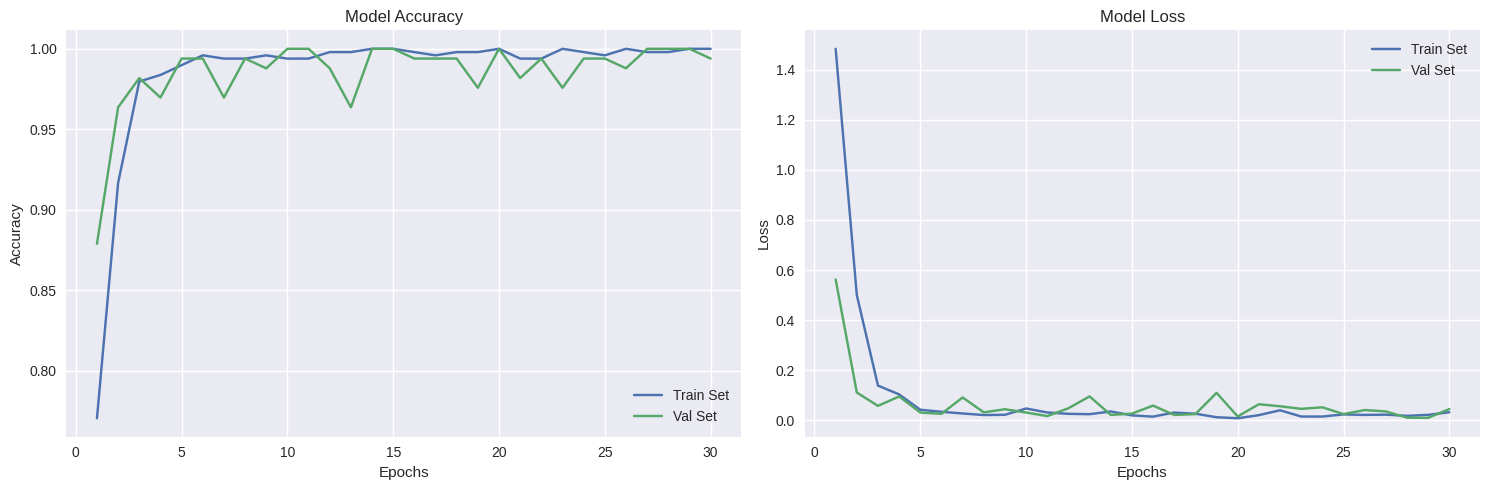

0.9857046107451121
0.09615097191805641
0.9854545513788859
0.06368798470745483


6/6 [==============================] - 3s 23ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        57
           1       1.00      0.99      1.00       108

    accuracy                           0.99       165
   macro avg       0.99      1.00      0.99       165
weighted avg       0.99      0.99      0.99       165

The AUC score for Efficient Net model is 1.0


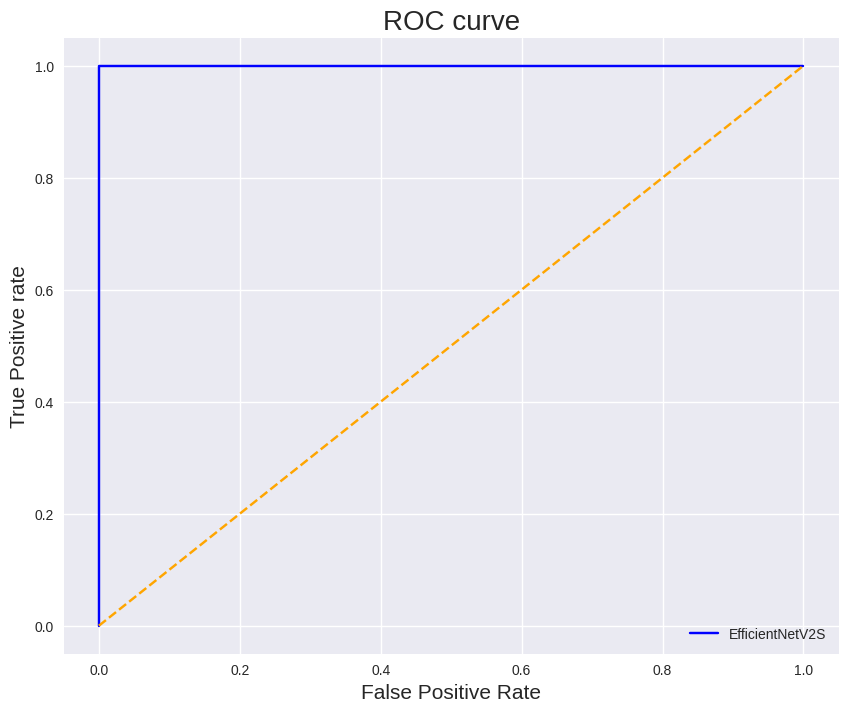

In [ ]:
EfficientNetmodel = EfficientNetV2S(weights = "imagenet", include_top = False,
                 input_tensor = Input(shape = (256,256,3)))
outputs = EfficientNetmodel.output
outputs = Flatten(name = "flatten")(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation = "sigmoid")(outputs)

model = Model(inputs=EfficientNetmodel.input, outputs=outputs)

for layers in EfficientNetmodel.layers:
  layers.trainable = False

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()

history=model.fit(X_train,y_train,
                  epochs = 30,
                  verbose = 1,
                  validation_data=(X_test,y_test),
                  batch_size = 16,
                  callbacks=lr_scheduler)

model.save('EfficientNet.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

print(statistics.mean(acc))
print(statistics.mean(loss))
print(statistics.mean(val_acc))
print(statistics.mean(val_loss))

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


pred_prob1 = model.predict_on_batch(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test.argmax(axis=1), pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test.argmax(axis=1), random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test.argmax(axis=1), pred_prob1[:,1])
print("The AUC score for Efficient Net model is {}".format(auc_score1))


plt.figure(figsize = (10, 8))
plt.plot(fpr1, tpr1, linestyle= None ,color='blue', label='EfficientNetV2S')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve',size = 20)
plt.xlabel('False Positive Rate',size = 15)
plt.ylabel('True Positive rate',size = 15)
plt.legend()
plt.savefig('ROC',dpi=700)
plt.show();

# MobileNet

17225924/17225924 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 128, 128, 32)     128  

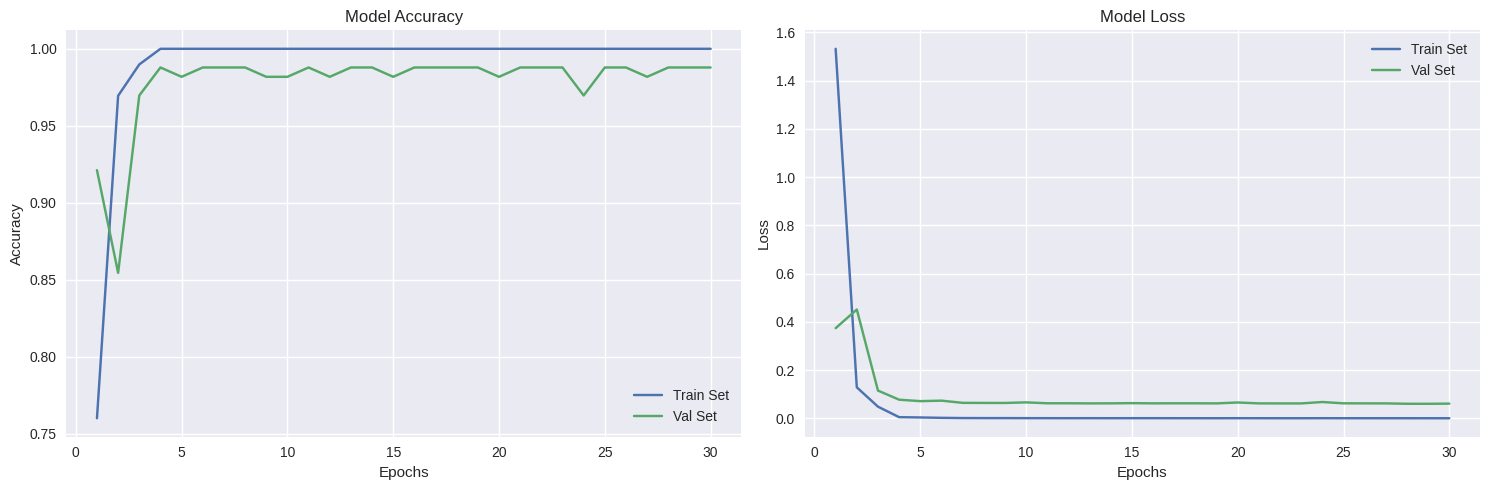

0.9906504074732463
0.05759919084084686
0.9785858730475108
0.08873231361309687


6/6 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        57
           1       0.99      0.99      0.99       108

    accuracy                           0.99       165
   macro avg       0.99      0.99      0.99       165
weighted avg       0.99      0.99      0.99       165

The AUC score for Mobile Net model is 0.99772579597141


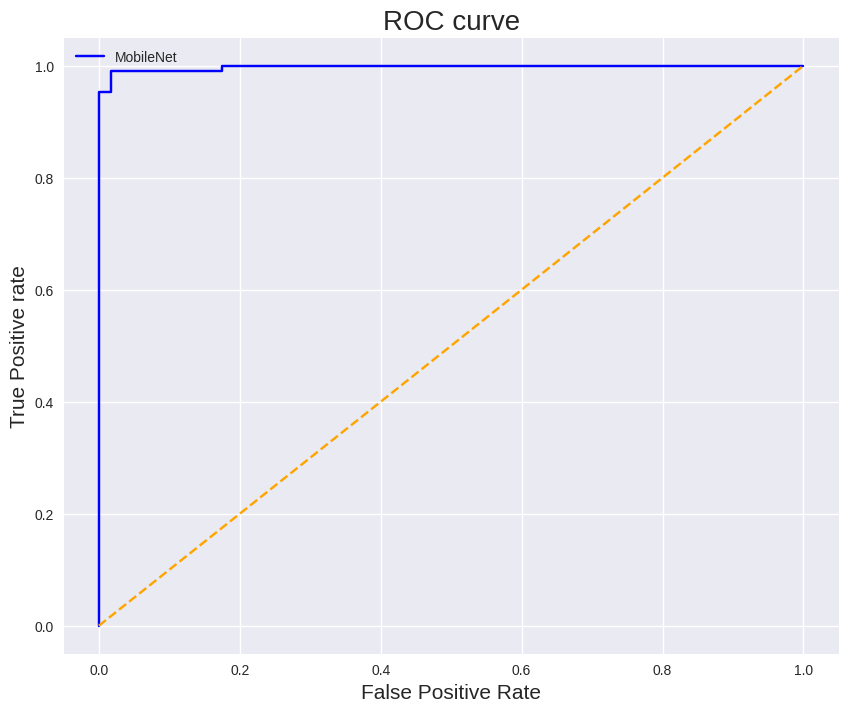

In [ ]:
MobileNetmodel = MobileNet(weights = "imagenet", include_top = False,
                 input_tensor = Input(shape = (256,256,3)))
outputs = MobileNetmodel.output
outputs = Flatten(name = "flatten")(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation = "sigmoid")(outputs)

model = Model(inputs= MobileNetmodel.input, outputs=outputs)

for layers in MobileNetmodel.layers:
  layers.trainable = False

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()

history=model.fit(X_train,y_train,
                  epochs = 30,
                  verbose = 1,
                  validation_data=(X_test,y_test),
                  batch_size = 16,
                  callbacks=lr_scheduler)
model.save('MobileNet.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

print(statistics.mean(acc))
print(statistics.mean(loss))
print(statistics.mean(val_acc))
print(statistics.mean(val_loss))

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


pred_prob1 = model.predict_on_batch(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test.argmax(axis=1), pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test.argmax(axis=1), random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test.argmax(axis=1), pred_prob1[:,1])
print("The AUC score for Mobile Net model is {}".format(auc_score1))


plt.figure(figsize = (10, 8))
plt.plot(fpr1, tpr1, linestyle= None ,color='blue', label='MobileNet')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve',size = 20)
plt.xlabel('False Positive Rate',size = 15)
plt.ylabel('True Positive rate',size = 15)
plt.legend()
plt.savefig('ROC',dpi=700)
plt.show();

# ResNet152

234698864/234698864 [==============================] - 2s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

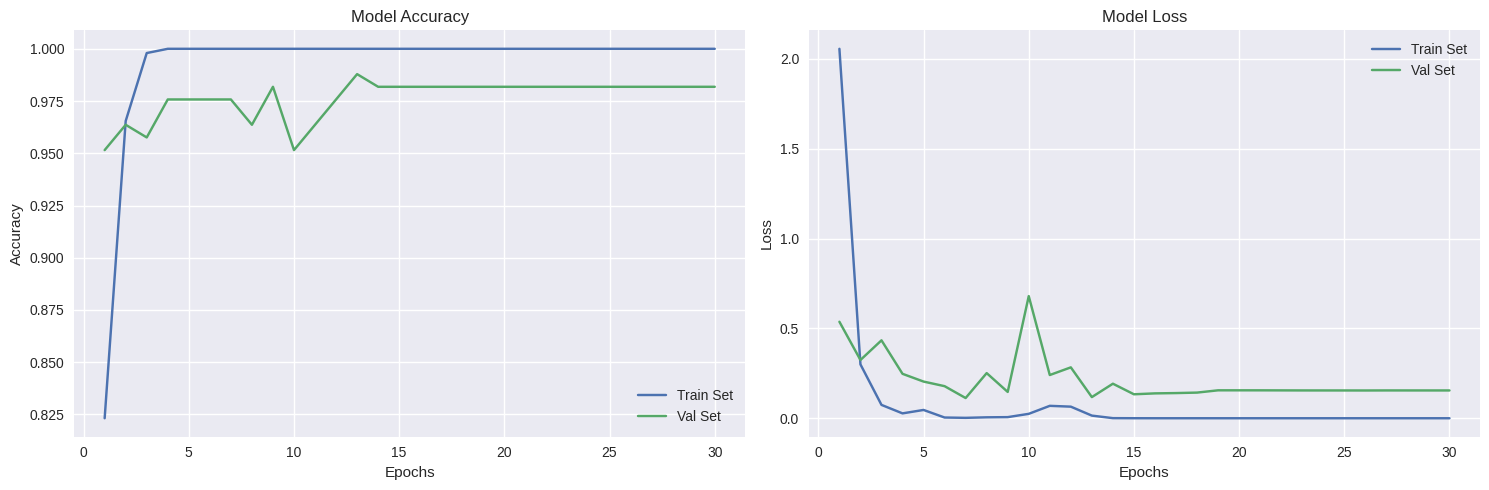

0.9928861776987712
0.08983003941552757
0.9763636469841004
0.2120821386575699
6/6 [==============================] - 3s 33ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        57
           1       1.00      0.97      0.99       108

    accuracy                           0.98       165
   macro avg       0.97      0.99      0.98       165
weighted avg       0.98      0.98      0.98       165

The AUC score for  ResNet model is 0.9990253411306043


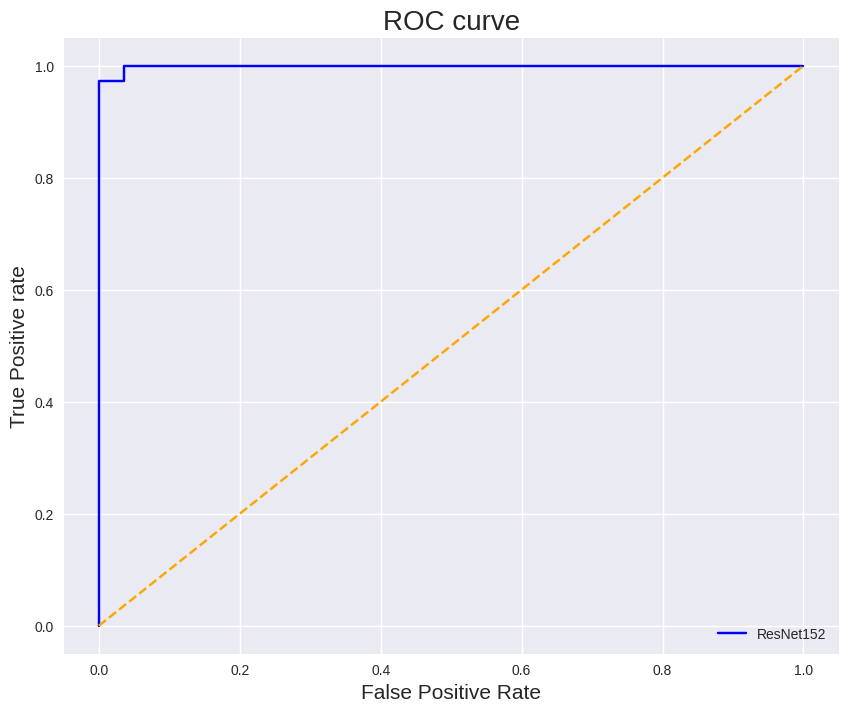

In [ ]:
ResNetmodel = ResNet152(weights = "imagenet", include_top = False,
                 input_tensor = Input(shape = (256,256,3)))
outputs = ResNetmodel.output
outputs = Flatten(name = "flatten")(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation = "sigmoid")(outputs)

model = Model(inputs= ResNetmodel.input, outputs=outputs)

for layers in ResNetmodel.layers:
  layers.trainable = False

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()

history=model.fit(X_train,y_train,
                  epochs = 30,
                  verbose = 1,
                  validation_data=(X_test,y_test),
                  batch_size = 16,
                  callbacks=lr_scheduler)
model.save('ResNet.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

print(statistics.mean(acc))
print(statistics.mean(loss))
print(statistics.mean(val_acc))
print(statistics.mean(val_loss))

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


pred_prob1 = model.predict_on_batch(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test.argmax(axis=1), pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test.argmax(axis=1), random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test.argmax(axis=1), pred_prob1[:,1])
print("The AUC score for  ResNet model is {}".format(auc_score1))


plt.figure(figsize = (10, 8))
plt.plot(fpr1, tpr1, linestyle= None ,color='blue', label='ResNet152')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve',size = 20)
plt.xlabel('False Positive Rate',size = 15)
plt.ylabel('True Positive rate',size = 15)
plt.legend()
plt.savefig('ROC',dpi=700)
plt.show();

# InceptionV3

87910968/87910968 [==============================] - 0s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                

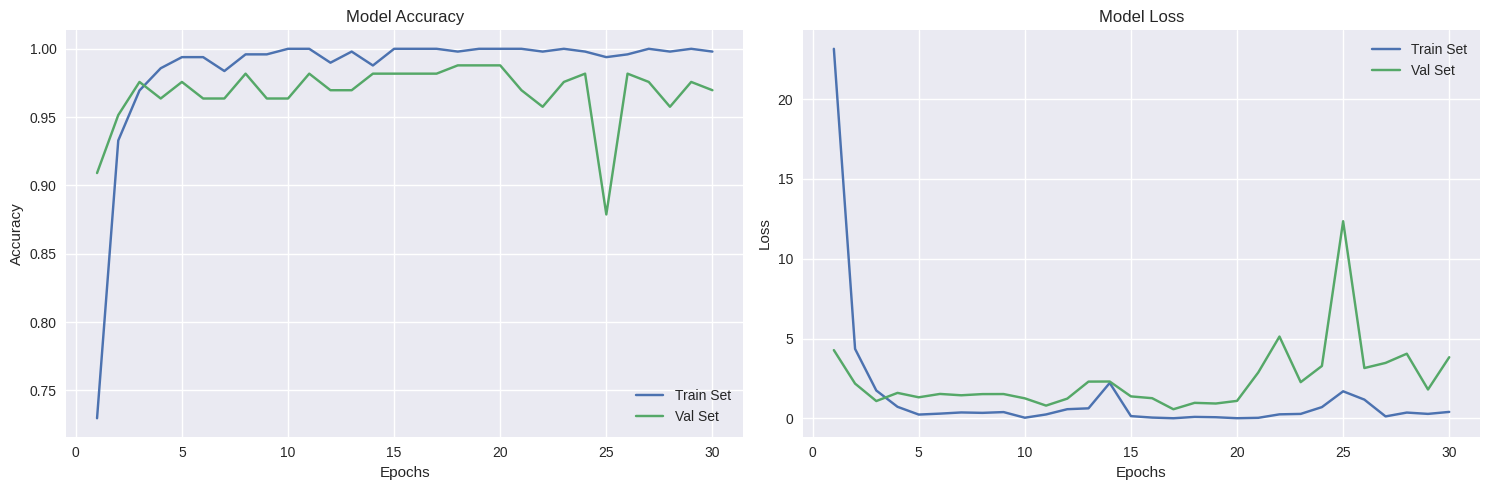

0.9845528503259023
1.360982039840504
0.968282836675644
2.421791233619054
6/6 [==============================] - 3s 13ms/step
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        57
           1       1.00      0.90      0.95       108

    accuracy                           0.93       165
   macro avg       0.92      0.95      0.93       165
weighted avg       0.94      0.93      0.93       165

The AUC score for Inception model is 0.9905782975958414


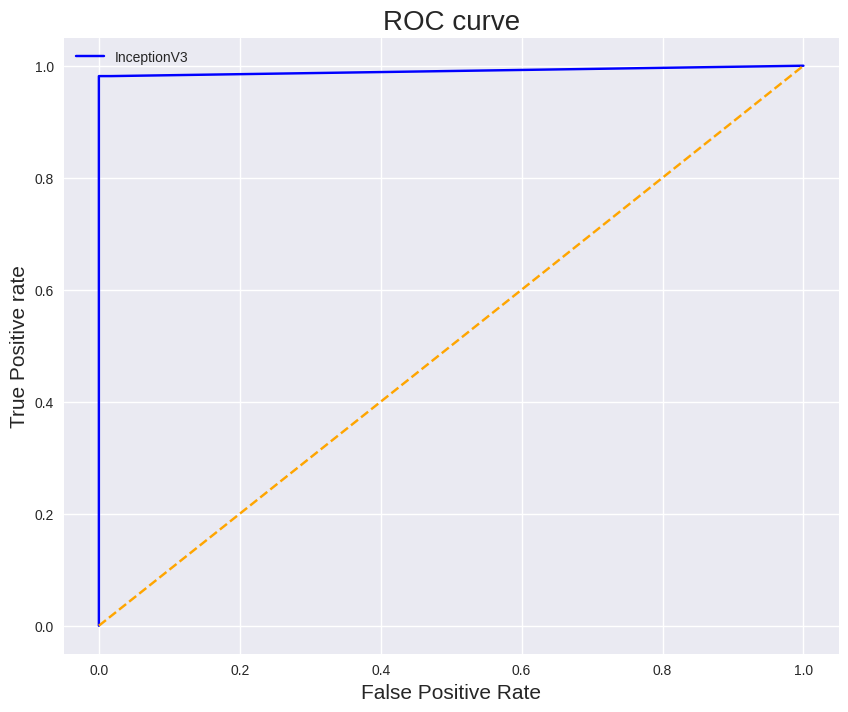

In [ ]:
inceptionmodel = InceptionV3(weights = "imagenet", include_top = False,
                 input_tensor = Input(shape = (256,256,3)))
outputs = inceptionmodel.output
outputs = Flatten(name = "flatten")(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation = "sigmoid")(outputs)

model = Model(inputs= inceptionmodel.input, outputs=outputs)

for layers in inceptionmodel.layers:
  layers.trainable = False

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()

history=model.fit(X_train,y_train,
                  epochs = 30,
                  verbose = 1,
                  validation_data=(X_test,y_test),
                  batch_size = 16,
                  callbacks=lr_scheduler)


model.save('inception.h5')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

print(statistics.mean(acc))
print(statistics.mean(loss))
print(statistics.mean(val_acc))
print(statistics.mean(val_loss))

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


pred_prob1 = model.predict_on_batch(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test.argmax(axis=1), pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test.argmax(axis=1), random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test.argmax(axis=1), pred_prob1[:,1])
print("The AUC score for Inception model is {}".format(auc_score1))


plt.figure(figsize = (10, 8))
plt.plot(fpr1, tpr1, linestyle= None ,color='blue', label='InceptionV3')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve',size = 20)
plt.xlabel('False Positive Rate',size = 15)
plt.ylabel('True Positive rate',size = 15)
plt.legend()
plt.savefig('ROC',dpi=700)
plt.show();

# NASNetLarge

343610240/343610240 [==============================] - 2s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 127, 127, 96  2592        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 127, 127, 96  384         ['stem_conv1[0][0]']             
                         

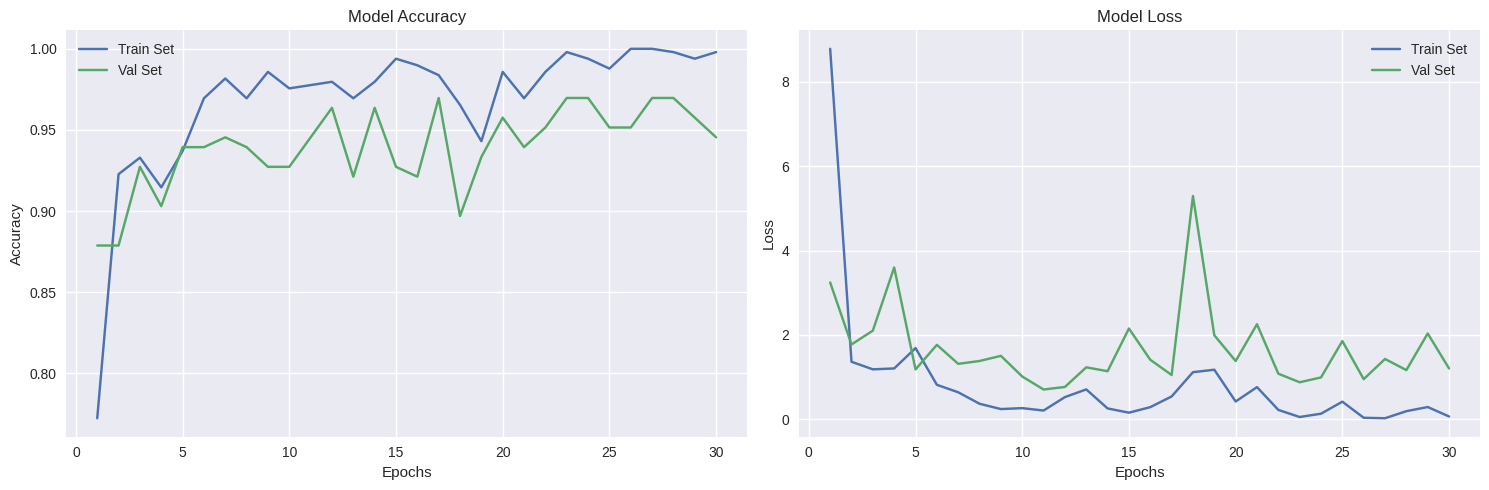

0.9684959451357523
0.803608846043547
0.9393939395745595
1.6603979865709941
6/6 [==============================] - 7s 74ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        57
           1       0.95      0.97      0.96       108

    accuracy                           0.95       165
   macro avg       0.95      0.93      0.94       165
weighted avg       0.95      0.95      0.95       165

The AUC score for NasNet model is 0.9938271604938271


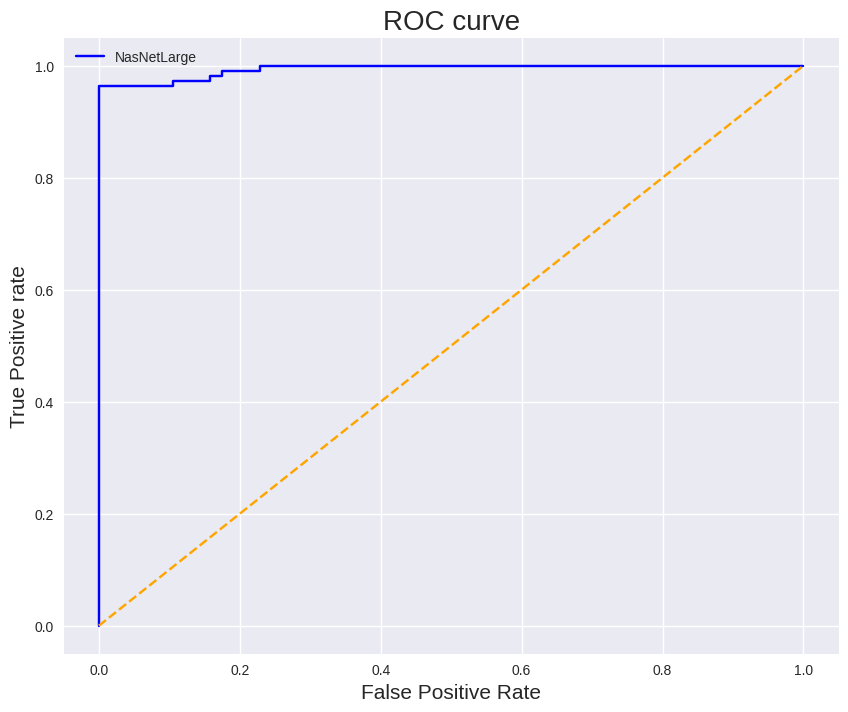

In [ ]:
NasNetmodel = NASNetLarge(weights = "imagenet", include_top = False,
                 input_tensor = Input(shape = (256,256,3)))
outputs = NasNetmodel.output
outputs = Flatten(name = "flatten")(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation = "sigmoid")(outputs)

model = Model(inputs= NasNetmodel.input, outputs=outputs)

for layers in NasNetmodel.layers:
  layers.trainable = False

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()

history=model.fit(X_train,y_train,
                  epochs = 30,
                  verbose = 1,
                  validation_data=(X_test,y_test),
                  batch_size = 16,
                  callbacks=lr_scheduler)
model.save('NasNet.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

print(statistics.mean(acc))
print(statistics.mean(loss))
print(statistics.mean(val_acc))
print(statistics.mean(val_loss))

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


pred_prob1 = model.predict_on_batch(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test.argmax(axis=1), pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test.argmax(axis=1), random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test.argmax(axis=1), pred_prob1[:,1])
print("The AUC score for NasNet model is {}".format(auc_score1))


plt.figure(figsize = (10, 8))
plt.plot(fpr1, tpr1, linestyle= None ,color='blue', label='NasNetLarge')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve',size = 20)
plt.xlabel('False Positive Rate',size = 15)
plt.ylabel('True Positive rate',size = 15)
plt.legend()
plt.savefig('ROC',dpi=700)
plt.show();

# Xception

83683744/83683744 [==============================] - 0s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                    

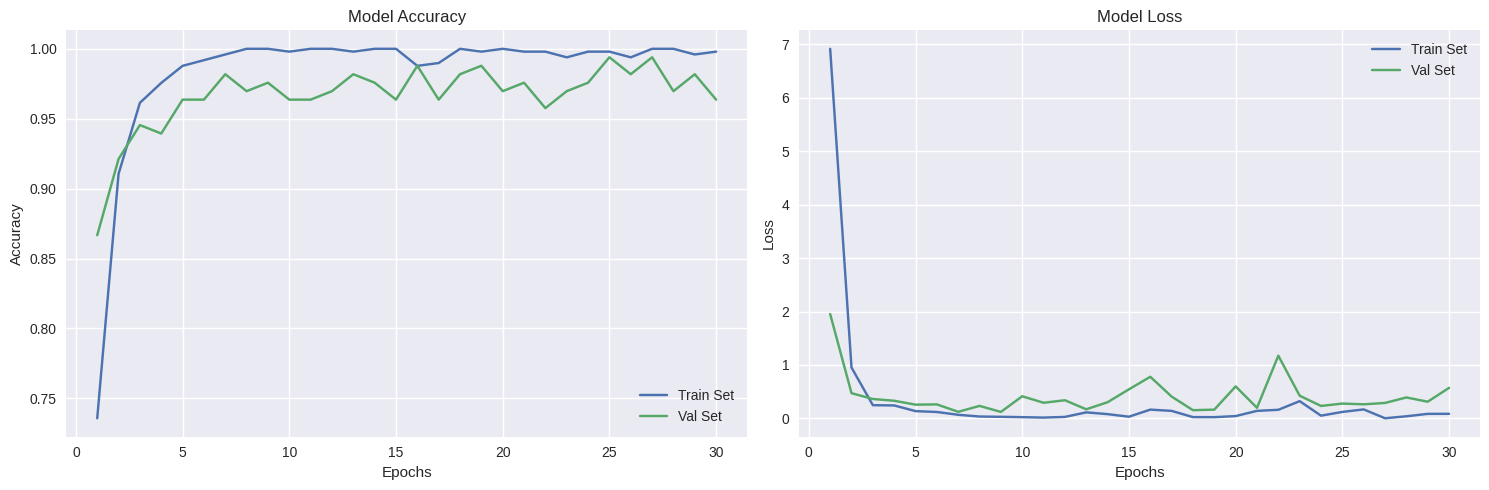

0.9834688385327657
0.354351759244067
0.9666666726271311
0.4145901138583819
6/6 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        57
           1       1.00      0.94      0.97       108

    accuracy                           0.96       165
   macro avg       0.95      0.97      0.96       165
weighted avg       0.97      0.96      0.96       165

The AUC score for Xception model is 0.9985380116959065


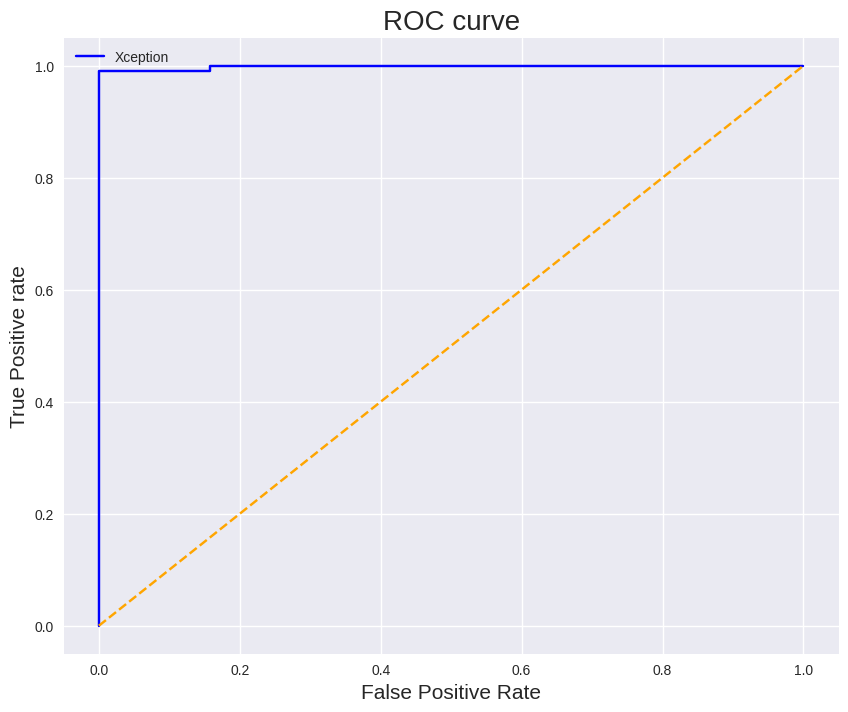

In [ ]:
xceptionmodel = Xception(weights = "imagenet", include_top = False,
                 input_tensor = Input(shape = (256,256,3)))
outputs = xceptionmodel.output
outputs = Flatten(name = "flatten")(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation = "sigmoid")(outputs)

model = Model(inputs= xceptionmodel.input, outputs=outputs)

for layers in xceptionmodel.layers:
  layers.trainable = False

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()

history=model.fit(X_train,y_train,
                  epochs = 30,
                  verbose = 1,
                  validation_data=(X_test,y_test),
                  batch_size = 16,
                  callbacks=lr_scheduler)
model.save('xception.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

print(statistics.mean(acc))
print(statistics.mean(loss))
print(statistics.mean(val_acc))
print(statistics.mean(val_loss))

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


pred_prob1 = model.predict_on_batch(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test.argmax(axis=1), pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test.argmax(axis=1), random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test.argmax(axis=1), pred_prob1[:,1])
print("The AUC score for Xception model is {}".format(auc_score1))


plt.figure(figsize = (10, 8))
plt.plot(fpr1, tpr1, linestyle= None ,color='blue', label='Xception')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve',size = 20)
plt.xlabel('False Positive Rate',size = 15)
plt.ylabel('True Positive rate',size = 15)
plt.legend()
plt.savefig('ROC',dpi=100)
plt.show();

In [ ]:
keras_model1 = tf.keras.models.load_model('VGG19.h5', compile=False)
keras_model1._name = 'model1'
keras_model2 = tf.keras.models.load_model('DenseNet.h5', compile=False)
keras_model2._name = 'model2'
keras_model3 = tf.keras.models.load_model('EfficientNet.h5', compile=False)
keras_model3._name = 'model3'
keras_model4 = tf.keras.models.load_model('MobileNet.h5', compile=False)
keras_model4._name = 'model4'
keras_model5 = tf.keras.models.load_model('ResNet.h5', compile=False)
keras_model5._name = 'model5'
keras_model6 = tf.keras.models.load_model('inception.h5', compile=False)
keras_model6._name = 'model6'
keras_model7 = tf.keras.models.load_model('NasNet.h5', compile=False)
keras_model7._name = 'model7'
keras_model8 = tf.keras.models.load_model('xception.h5', compile=False)
keras_model8._name = 'model8'

In [ ]:
models = [keras_model1,
          keras_model2,
          keras_model3,
          keras_model4,
          keras_model5,
          keras_model6,
          keras_model7,
          keras_model8
          ]
model_input = tf.keras.Input(shape=(256,256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs = model_input, 
                                outputs = ensemble_output, 
                                name='ensemble')
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model1 (Functional)            (None, 2)            20089922    ['input_9[0][0]']                
                                                                                                  
 model2 (Functional)            (None, 2)            18567746    ['input_9[0][0]']                
                                                                                                  
 model3 (Functional)            (None, 2)            20495202    ['input_9[0][0]']         

In [ ]:
ensemble_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

ensemble_model.compile(optimizer=opt, 
                       loss=tf.keras.losses.BinaryCrossentropy(from_logits = False), 
                       metrics=[tf.keras.metrics.BinaryAccuracy(),
                               tf.keras.metrics.Precision(),
                               tf.keras.metrics.Recall()])

es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                      patience = 5, verbose = 1)

rd_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                             factor = np.sqrt(0.14), 
                                             patience= 2, verbose = 1, 
                                             min_lr = 5e-8)

history = ensemble_model.fit(X_train,y_train, epochs = 50, 
                             validation_data= (X_test,y_test),
                             verbose = 1,
                             callbacks = lr_scheduler
                             )

Epoch 1/50
16/16 [==============================] - 90s 2s/step - loss: 0.0776 - binary_accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.1040 - val_binary_accuracy: 0.9939 - val_precision_1: 1.0000 - val_recall_1: 0.9879 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 5s 326ms/step - loss: 0.0697 - binary_accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.0984 - val_binary_accuracy: 0.9939 - val_precision_1: 1.0000 - val_recall_1: 0.9879 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 5s 327ms/step - loss: 0.0682 - binary_accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.0875 - val_binary_accuracy: 0.9909 - val_precision_1: 1.0000 - val_recall_1: 0.9818 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 5s 325ms/step - loss: 0.0661 - binary_accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.0848 - val_binary_accuracy: 0.9939 - val_precision_1: 0.9939 - 

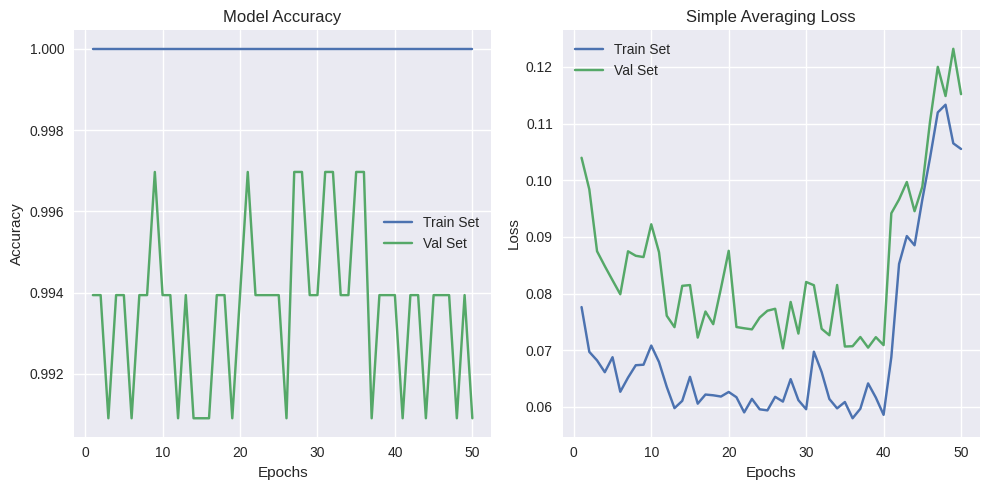

0.9936363697052002
0.9970857203006744
0.990181827545166
6/6 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        57
           1       1.00      0.94      0.97       108

    accuracy                           0.96       165
   macro avg       0.95      0.97      0.96       165
weighted avg       0.97      0.96      0.96       165

The AUC score for Simple Averaging ensemble model is 0.9985380116959065


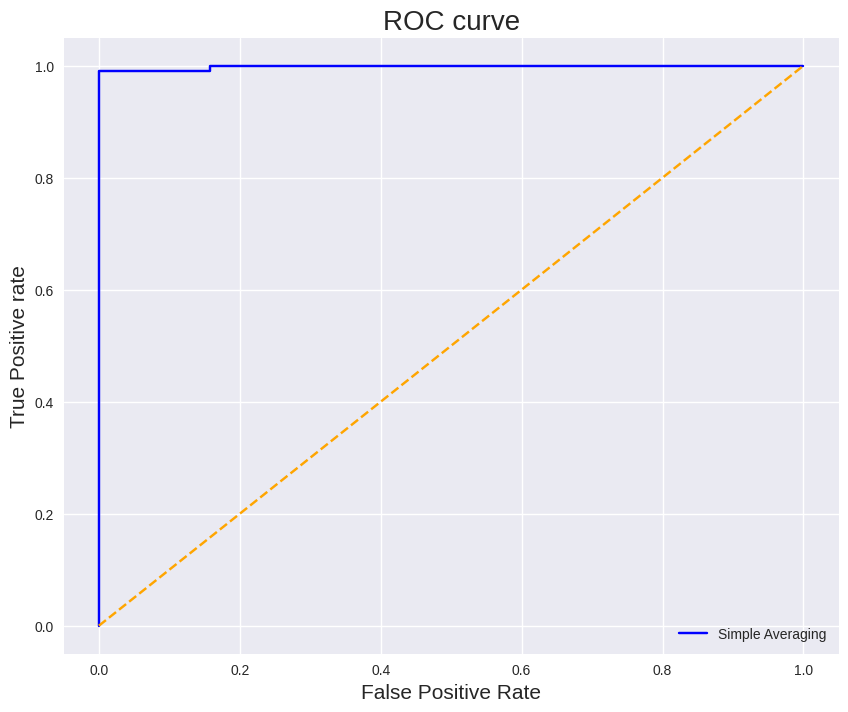

In [ ]:
ensemble_model.save('Simple Ensemble.h5')
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_precision = history.history['val_precision_1']
val_recall = history.history['val_recall_1']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Simple Averaging Loss')
plt.savefig('Simple Averaging Loss',dpi = 800)

plt.tight_layout()
plt.show()


print(statistics.mean(val_acc))
print(statistics.mean(val_precision))
print(statistics.mean(val_recall))

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


pred_prob1 = model.predict_on_batch(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test.argmax(axis=1), pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test.argmax(axis=1), random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test.argmax(axis=1), pred_prob1[:,1])
print("The AUC score for Simple Averaging ensemble model is {}".format(auc_score1))


plt.figure(figsize = (10, 8))
plt.plot(fpr1, tpr1, linestyle= None ,color='blue', label='Simple Averaging')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve',size = 20)
plt.xlabel('False Positive Rate',size = 15)
plt.ylabel('True Positive rate',size = 15)
plt.legend()
plt.savefig('ROC',dpi=100)
plt.show();

In [ ]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, w3, w4, w5, w6, w7, w8, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.w4 = w4
        self.w5 = w5
        self.w6 = w6
        self.w7 = w7
        self.w8 = w8

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] + self.w3 * inputs[2] + self.w4 * inputs[3] + self.w5 * inputs[4] + self.w6 * inputs[5] +  self.w7 * inputs[6] + self.w8 * inputs[7]

In [ ]:
models = [keras_model1,
          keras_model2,
          keras_model3,
          keras_model4,
          keras_model5,
          keras_model6,
          keras_model7,
          keras_model8
          ]
model_input = tf.keras.Input(shape=(256,256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = WeightedAverageLayer(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1)(model_outputs)
ensemble_model = tf.keras.Model(inputs = model_input, 
                                outputs = ensemble_output, 
                                name='ensemble')
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model1 (Functional)            (None, 2)            20089922    ['input_42[0][0]']               
                                                                                                  
 model2 (Functional)            (None, 2)            18567746    ['input_42[0][0]']               
                                                                                                  
 model3 (Functional)            (None, 2)            20495202    ['input_42[0][0]']        

In [ ]:
ensemble_model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

ensemble_model.compile(optimizer=opt, 
                       loss=tf.keras.losses.BinaryCrossentropy(from_logits = False), 
                       metrics=[tf.keras.metrics.BinaryAccuracy(),
                               tf.keras.metrics.Precision(),
                               tf.keras.metrics.Recall()])

es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                      patience = 5, verbose = 1)

rd_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                             factor = np.sqrt(0.14), 
                                             patience= 2, verbose = 1, 
                                             min_lr = 5e-8)

history = ensemble_model.fit(X_train,y_train, epochs = 100, 
                             validation_data= (X_test,y_test),
                             verbose = 1,
                             callbacks = lr_scheduler
                             )

Epoch 1/100
16/16 [==============================] - 84s 2s/step - loss: 0.1855 - binary_accuracy: 1.0000 - precision_29: 1.0000 - recall_29: 1.0000 - val_loss: 0.1962 - val_binary_accuracy: 0.9939 - val_precision_29: 0.9939 - val_recall_29: 0.9939 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 6s 363ms/step - loss: 0.1748 - binary_accuracy: 1.0000 - precision_29: 1.0000 - recall_29: 1.0000 - val_loss: 0.1947 - val_binary_accuracy: 0.9939 - val_precision_29: 1.0000 - val_recall_29: 0.9879 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 6s 365ms/step - loss: 0.1761 - binary_accuracy: 1.0000 - precision_29: 1.0000 - recall_29: 1.0000 - val_loss: 0.1949 - val_binary_accuracy: 0.9939 - val_precision_29: 1.0000 - val_recall_29: 0.9879 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 6s 364ms/step - loss: 0.1738 - binary_accuracy: 1.0000 - precision_29: 1.0000 - recall_29: 1.0000 - val_loss: 0.1907 - val_binary_accuracy: 1.0000 - val_prec

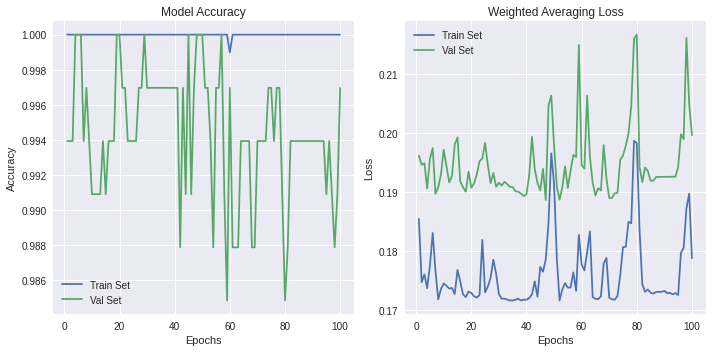

0.9943939447402954
0.9972700262069703
0.9915151596069336
6/6 [==============================] - 0s 31ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        57
           1       0.99      1.00      1.00       108

    accuracy                           0.99       165
   macro avg       1.00      0.99      0.99       165
weighted avg       0.99      0.99      0.99       165

The AUC score for Weighted Averaging ensemble model is 1.0


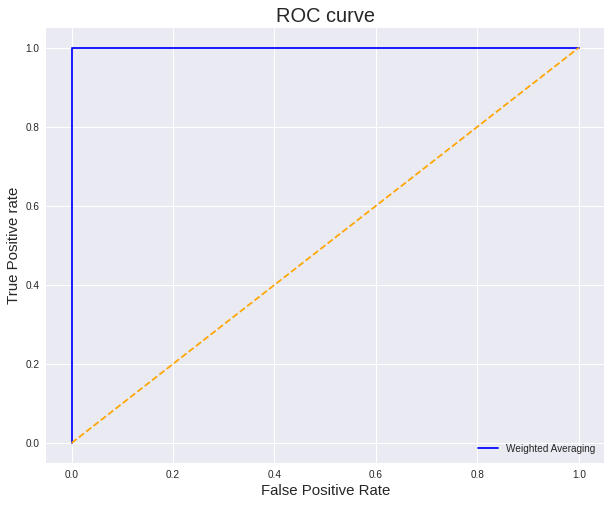

In [ ]:
#ensemble_model.save('Weighted Ensemble.h5')
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_precision = history.history['val_precision_29']
val_recall = history.history['val_recall_29']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Weighted Averaging Loss')
plt.savefig('Weighted Averaging Loss',dpi = 800)

plt.tight_layout()
plt.show()


print(statistics.mean(val_acc))
print(statistics.mean(val_precision))
print(statistics.mean(val_recall))

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


pred_prob1 = model.predict_on_batch(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test.argmax(axis=1), pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test.argmax(axis=1), random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test.argmax(axis=1), pred_prob1[:,1])
print("The AUC score for Weighted Averaging ensemble model is {}".format(auc_score1))


plt.figure(figsize = (10, 8))
plt.plot(fpr1, tpr1, linestyle= None ,color='blue', label='Weighted Averaging')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve',size = 20)
plt.xlabel('False Positive Rate',size = 15)
plt.ylabel('True Positive rate',size = 15)
plt.legend()
plt.savefig('ROC',dpi=100)
plt.show();